In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SegmentationItemListSplitBatch
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, test_showing, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

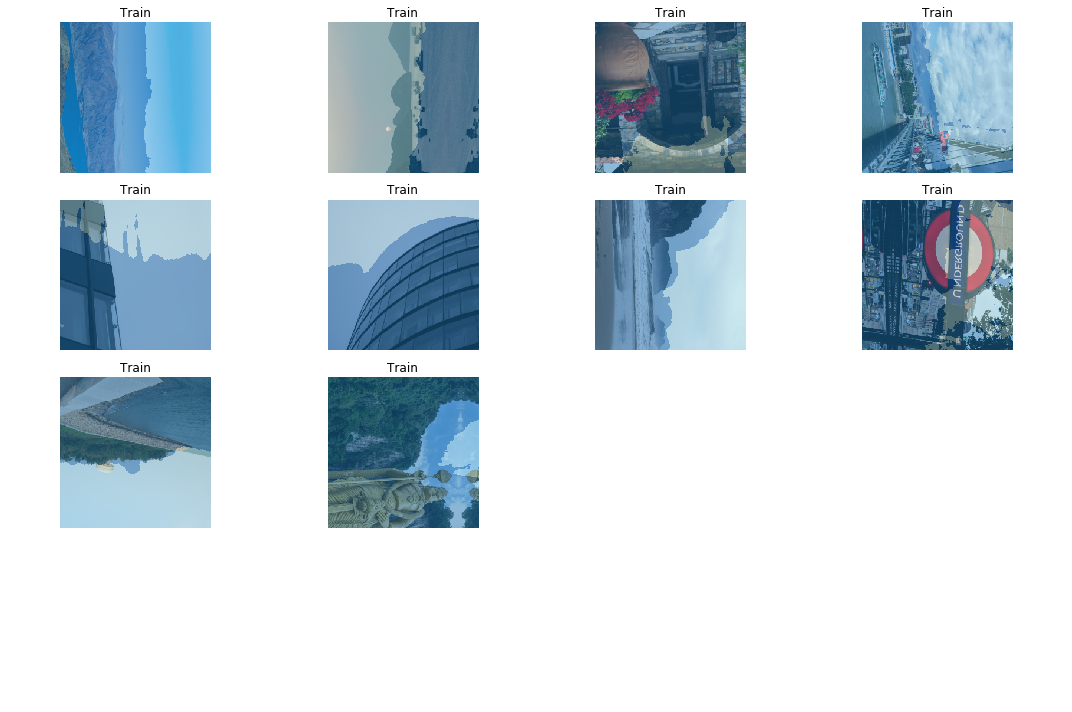

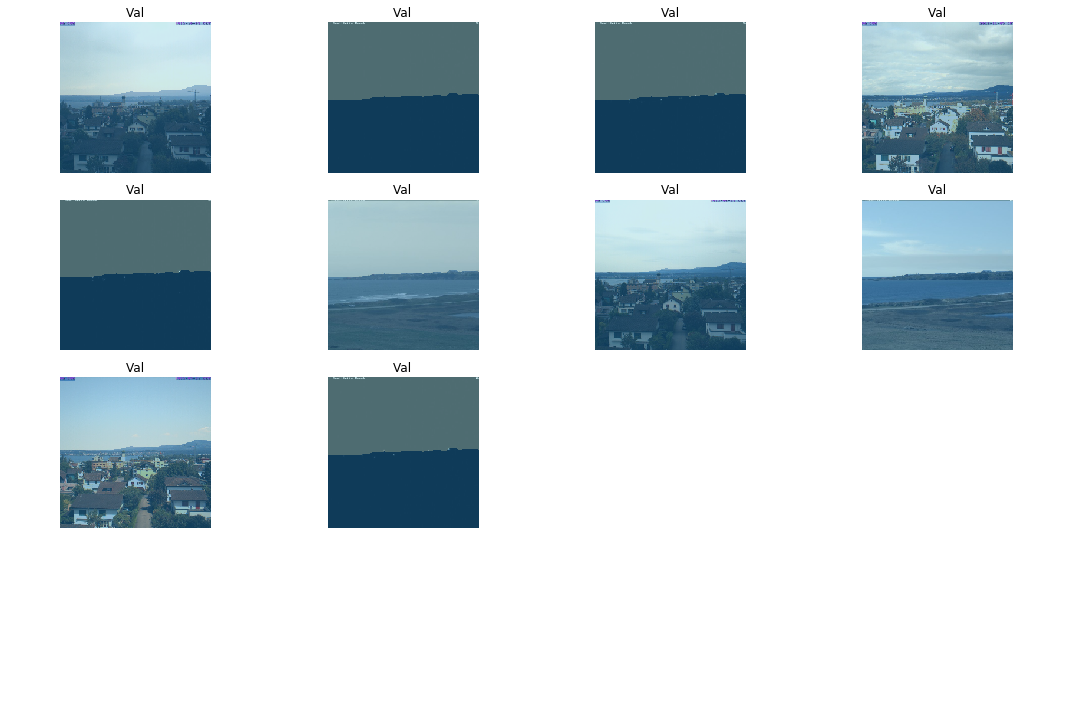

In [4]:
sizes = 256

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train_raw", "val_skyFinder")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms(flip_vert=True)
                  , size=sizes, tfm_y=True)
    .databunch(bs=10)
    .normalize(imagenet_stats)
)
classes = train_data.c

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [17]:
train_data.train_ds[0]

(Image (3, 256, 256), ImageSegment (1, 256, 256))

In [15]:
model = LinkNet34(num_classes=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.10E-03


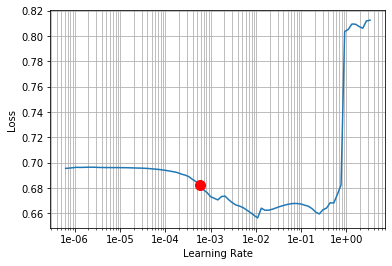

In [16]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [6]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_osp_full_s256_mlr2e02_e100_bs24")

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.059195,0.222360,0.920536,84.949321,85.621857,02:33
1,0.047844,0.235485,0.918523,83.602901,86.114660,02:33
2,0.045148,0.195390,0.938853,87.447379,89.362989,02:33
3,0.041126,0.263954,0.906237,81.380117,84.175757,02:33
4,0.047290,0.725311,0.842020,68.522532,76.165882,02:33
5,0.049886,0.140900,0.955543,91.273536,91.708695,02:33
6,0.041909,0.272383,0.916153,82.900173,85.915942,02:33
7,0.048408,0.201496,0.918555,83.521508,86.163333,02:32
8,0.048543,0.280769,0.916239,83.303790,85.671393,02:32
9,0.042320,0.189667,0.916467,83.164151,85.847696,02:33


profiler execution failed


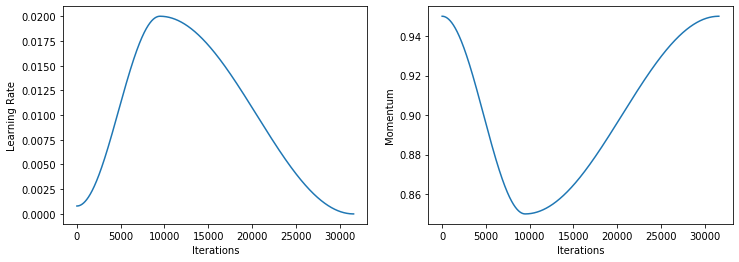

In [7]:
learner.fit_one_cycle(100, max_lr=2e-02, callbacks=[tb_callback(learner)])
# learner.fit(50, lr=1e-02, callbacks=[tb_callback(learner)])
# learner.fit(10)
# learner.fit_one_cycle(10, max_lr=2e-01)
learner.recorder.plot_lr(show_moms=True)

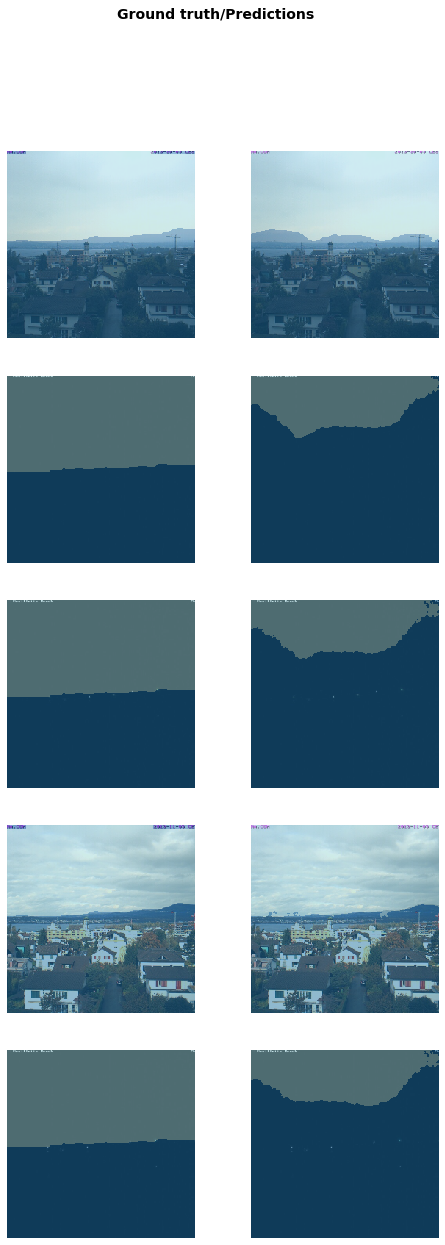

In [8]:
learner.show_results()

In [9]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_ops_full_e100_wghts")
learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_ops_full_e100_exp")